# Laden der Daten und Inspizieren der Daten (kopiert)

In [15]:
notebook_title = "unet_data_augmented_dropout_batch_normalization"

In [8]:
%run ./utils/load_data.ipynb

No of images:  290
No of masks:  290
(290, 224, 224, 3)
Loaded 290 images and masks.


# Data augmentation


In [9]:
# import import_ipynb
# from utils.data_augmentation import augment

# augmented_images, augmented_masks = augment(images, masks)

%run ./utils/data_augmentation.ipynb

print("Dataset size before augmentation: ", images.shape[0])
print("Dataset size after augmentation:", augmented_images.shape[0])

Dataset size before augmentation:  290
Dataset size after augmentation: 2610


### Auteilung in Train und Validation Daten
- 70% Training
- 15% Validierung
- 15% Test

In [10]:
# Train-validation-test split
from sklearn.model_selection import train_test_split

# First split: training set and temporary set (30% goes to temp)
X_train, X_temp, y_train, y_temp = train_test_split(augmented_images, augmented_masks, test_size=0.3, random_state=42)

# Second split: divide temp set into validation and test sets (50% each → 15% each of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset shapes
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

Train: (1827, 224, 224, 3)
Val:   (391, 224, 224, 3)
Test:  (392, 224, 224, 3)


#### Tensorflow Speicherwachstum erlauben - verhindert Pre-Allocation

In [11]:
# limit the usage of GPU memory

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

RuntimeError: Physical devices cannot be modified after being initialized

# Model

In [35]:
import import_ipynb
from utils.iou import iou_metric
from utils.precision_recall_f1 import precision_metric, recall_metric, f1_metric

from utils.u_net_v3_dropout_transpose import unet_model

model = unet_model((IMG_HEIGHT, IMG_WIDTH, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric, precision_metric, recall_metric, f1_metric])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 224, 224,  │        448 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 224, 224,  │      2,320 │ conv2d_45[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 112, 112,  │          0 │ conv2d_46[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 112, 112,  │          0 │ max_pooling2d_9[… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 112, 112,  │      4,640 │ dropout_21[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 112, 112,  │      9,248 │ conv2d_47[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 56, 56,    │          0 │ conv2d_48[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 56, 56,    │          0 │ max_pooling2d_10… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 56, 56,    │     18,496 │ dropout_22[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 56, 56,    │     36,928 │ conv2d_49[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 28, 28,    │          0 │ conv2d_50[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 28, 28,    │          0 │ max_pooling2d_11… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 28, 28,    │     73,856 │ dropout_23[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 28, 28,    │    147,584 │ conv2d_51[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 28, 28,    │          0 │ conv2d_52[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 56, 56,    │     32,832 │ dropout_24[0][0]

 Total params: 482,033 (1.84 MB)

 Trainable params: 482,033 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
BATCH_SIZE = 32

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=BATCH_SIZE
)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy: 0.6424 - f1_metric: 0.5023 - iou_metric: 0.3709 - loss: 0.6181 - precision_metric: 0.6358 - recall_metric: 0.5394 - val_accuracy: 0.7626 - val_f1_metric: 0.7401 - val_iou_metric: 0.5885 - val_loss: 0.4618 - val_precision_metric: 0.7427 - val_recall_metric: 0.7394
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7678 - f1_metric: 0.7374 - iou_metric: 0.5862 - loss: 0.4647 - precision_metric: 0.7557 - recall_metric: 0.7275 - val_accuracy: 0.7699 - val_f1_metric: 0.7342 - val_iou_metric: 0.5810 - val_loss: 0.4423 - val_precision_metric: 0.7809 - val_recall_metric: 0.6946
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7705 - f1_metric: 0.7279 - iou_metric: 0.5749 - loss: 0.4544 - precision_metric: 0.7891 - recall_metric: 0.6916 - val_accuracy: 0.7797 - val_f1_metric: 0.7337 - val_iou_metric: 0.5804 - val_loss: 0.4200 - val_precision_metric: 0.8295 - val_recall_metric: 0.6596
Epoch 4/50
58/58 

Die Werte der Metrik "Intersection over Union (IoU)" hat sich eigentlich nicht verbessert auf dem Validation Set. Es war schon besser ohne Dropout.

# Nach 50 Epochen

## 2025-06-17
accuracy: 0.8965 - f1_metric: 0.9019 - iou_metric: 0.8217 - loss: 0.1886 - precision_metric: 0.9212 - recall_metric: 0.8844 - val_accuracy: 0.8866 - val_f1_metric: 0.8917 - val_iou_metric: 0.8048 - val_loss: 0.2187 - val_precision_metric: 0.9006 - val_recall_metric: 0.8835

## 2025-06-17
accuracy: 0.8887 - f1_metric: 0.8955 - iou_metric: 0.8111 - loss: 0.2115 - precision_metric: 0.9113 - recall_metric: 0.8807 - val_accuracy: 0.8856 - val_f1_metric: 0.8906 - val_iou_metric: 0.8030 - val_loss: 0.2193 - val_precision_metric: 0.8936 - val_recall_metric: 0.8881

## 2025-06-17
accuracy: 0.8820 - f1_metric: 0.8848 - iou_metric: 0.7941 - loss: 0.2279 - precision_metric: 0.9004 - recall_metric: 0.8717 - val_accuracy: 0.8789 - val_f1_metric: 0.8815 - val_iou_metric: 0.7883 - val_loss: 0.2303 - val_precision_metric: 0.8918 - val_recall_metric: 0.8719

## Model speichern

In [37]:
model.save(f'./trained_models/{notebook_title}_batch_size_{BATCH_SIZE}.keras')

# Diagramme

In [38]:
print(history.history.keys())

dict_keys(['accuracy', 'f1_metric', 'iou_metric', 'loss', 'precision_metric', 'recall_metric', 'val_accuracy', 'val_f1_metric', 'val_iou_metric', 'val_loss', 'val_precision_metric', 'val_recall_metric'])


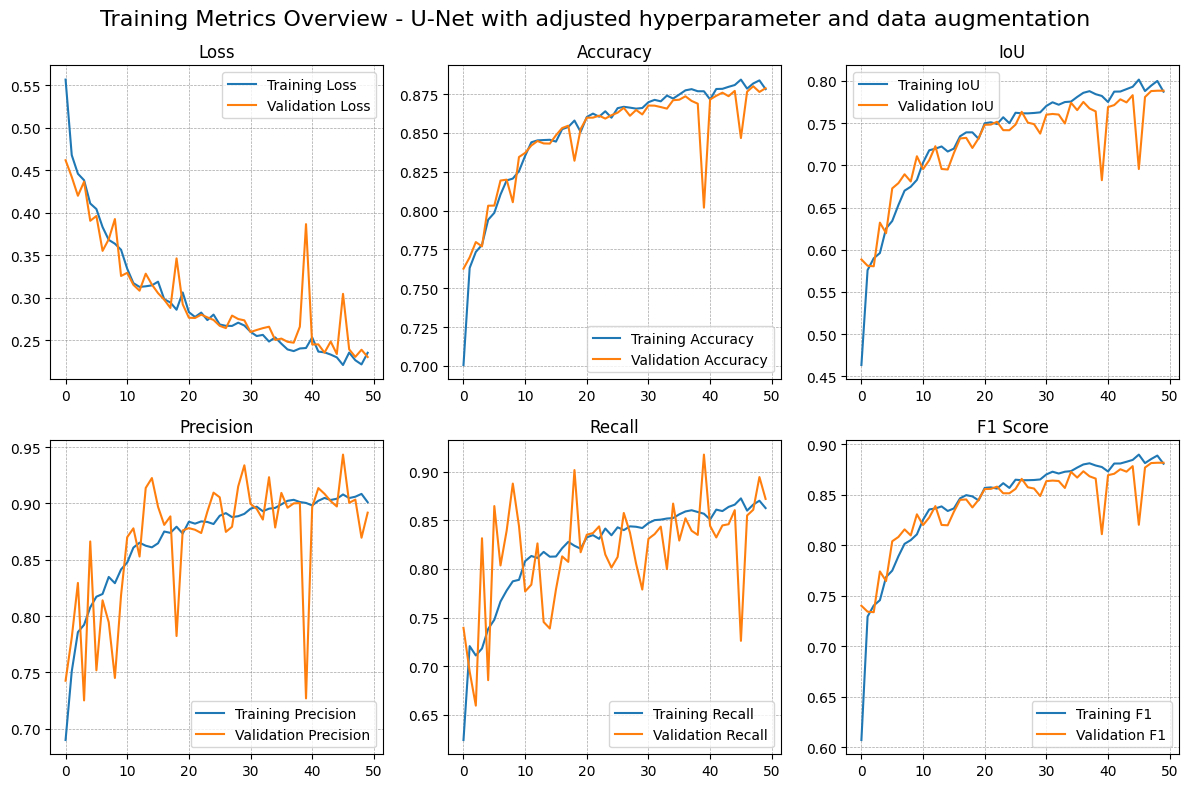

In [39]:
# Plot training history
from datetime import datetime
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('Loss')

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('Accuracy')

#IoU
plt.subplot(2, 3, 3)
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('IoU')

# Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision_metric'], label='Training Precision')
plt.plot(history.history['val_precision_metric'], label='Validation Precision')
plt.title('Precision')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

# Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall_metric'], label='Training Recall')
plt.plot(history.history['val_recall_metric'], label='Validation Recall')
plt.title('Recall')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

# F1 Score
plt.subplot(2, 3, 6)
plt.plot(history.history['f1_metric'], label='Training F1')
plt.plot(history.history['val_f1_metric'], label='Validation F1')
plt.title('F1 Score')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color


plt.suptitle('Training Metrics Overview - U-Net with adjusted hyperparameter and data augmentation', fontsize=16)
plt.tight_layout()
plt.savefig(f'./img/training_metrics/{notebook_title}_batch_size_{BATCH_SIZE}_{datetime.now().isoformat()}.png', dpi=300, bbox_inches='tight')
plt.show()

Was die Diagramme zeigen:

Es gibt keine relevante Verbesserung im Vergleich mit standard U-Net mit dropout

### Modell evaluieren mit Testdaten

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Prediction and binarization
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
y_true_binary = (y_test > 0.5).astype(int)

# Flatten
y_true_flat = y_true_binary.flatten()
y_pred_flat = y_pred_binary.flatten()

# Metrics
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
iou = jaccard_score(y_true_flat, y_pred_flat)

# Output
print("\n===== Final Test Evaluation =====")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"IoU:       {iou:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step

===== Final Test Evaluation =====
Precision: 0.8953
Recall:    0.8713
F1 Score:  0.8831
IoU:       0.7907



## 2025.06.17
===== Final Test Evaluation =====
Precision: 0.9013
Recall:    0.8836
F1 Score:  0.8924
IoU:       0.8057

## 2025.06.17
===== Final Test Evaluation =====
Precision: 0.8951
Recall:    0.8881
F1 Score:  0.8916
IoU:       0.8044

## 2025.06.17
===== Final Test Evaluation =====
Precision: 0.8953
Recall:    0.8713
F1 Score:  0.8831
IoU:       0.7907

#### Vergleich der Metriken für Train, Validation und Test

In [41]:
import import_ipynb
from utils.metrics_barplot import metrics_summary

metrics_summary_results = metrics_summary(history, y_true_flat, y_pred_flat, precision, recall, f1, iou)

print("\n===== Training, Validation und Test Metriken =====")
print(metrics_summary_results.to_string(index=False, float_format="%.4f"))


===== Training, Validation und Test Metriken =====
  Set  Accuracy  Precision  Recall  F1 Score    IoU
Train    0.8783     0.9011  0.8625    0.8805 0.7872
  Val    0.8789     0.8918  0.8719    0.8815 0.7883
 Test    0.9095     0.8953  0.8713    0.8831 0.7907


Es sieht nicht so aus, als es sich etwas verbessert hat im Vergleich zu U_net mit dropout


## 2025.06.17
===== Training, Validation und Test Metriken =====
  Set  Accuracy  Precision  Recall  F1 Score    IoU
Train    0.8946     0.9173  0.8878    0.9020 0.8219
  Val    0.8866     0.9006  0.8835    0.8917 0.8048
 Test    0.9164     0.9013  0.8836    0.8924 0.8057

## 2025.06.17
===== Training, Validation und Test Metriken =====
  Set  Accuracy  Precision  Recall  F1 Score    IoU
Train    0.8901     0.9135  0.8822    0.8974 0.8143
  Val    0.8856     0.8936  0.8881    0.8906 0.8030
 Test    0.9152     0.8951  0.8881    0.8916 0.8044

## 2025.06.17
===== Training, Validation und Test Metriken =====
  Set  Accuracy  Precision  Recall  F1 Score    IoU
Train    0.8783     0.9011  0.8625    0.8805 0.7872
  Val    0.8789     0.8918  0.8719    0.8815 0.7883
 Test    0.9095     0.8953  0.8713    0.8831 0.7907

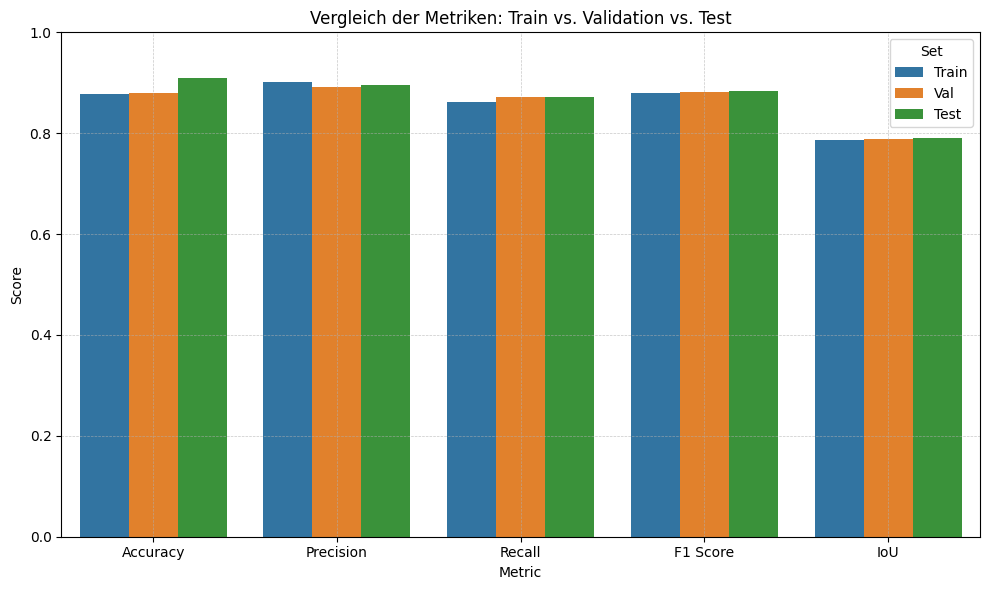

In [42]:
import import_ipynb
from utils.metrics_barplot import draw_metrics_barplot

draw_metrics_barplot(metrics_summary_results, save_title=f"{notebook_title}_batch_size_{BATCH_SIZE}")

# Visualize predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


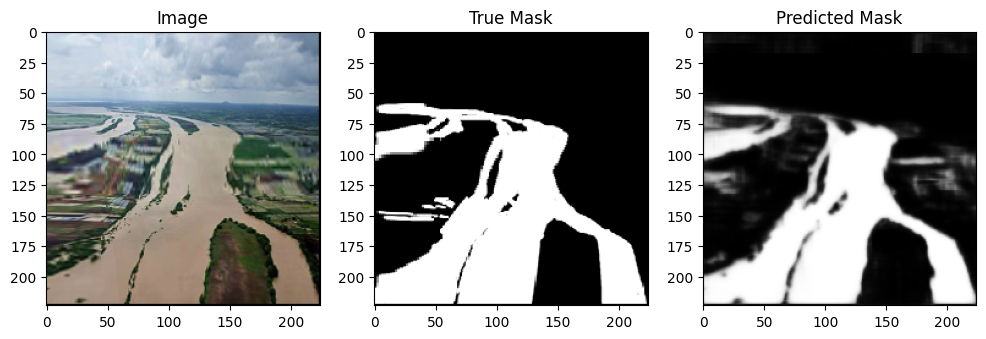

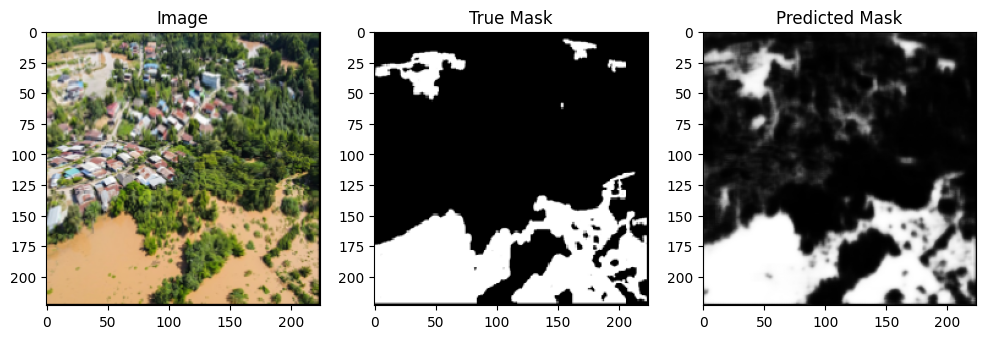

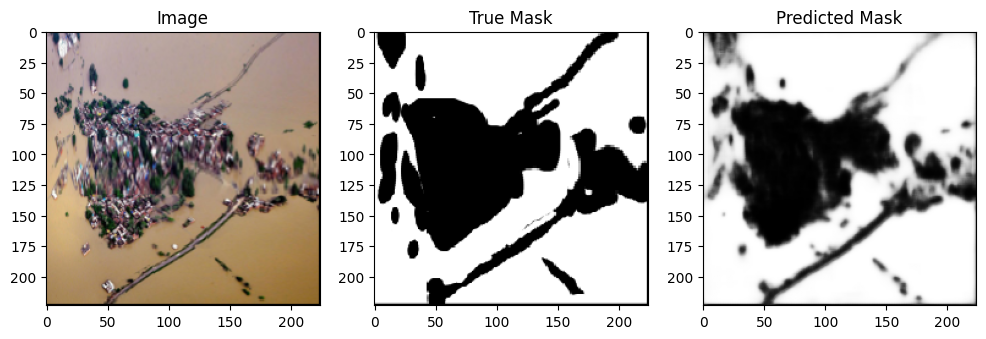

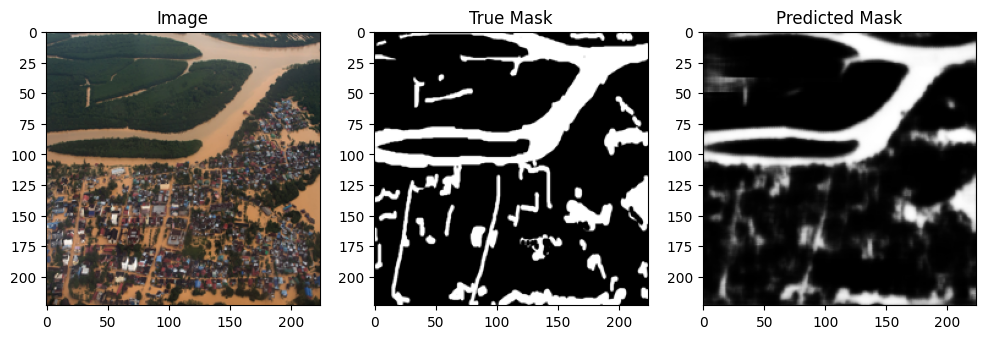

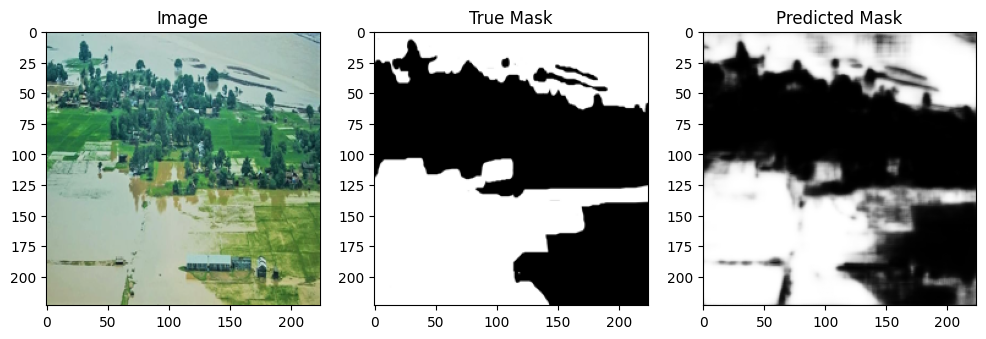

In [43]:
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow.keras.models import load_model

# Imports relevant for loading the model
import import_ipynb
from utils.iou import iou_metric
from utils.precision_recall_f1 import precision_metric, recall_metric, f1_metric

model = load_model(f'./trained_models/{notebook_title}_batch_size_{BATCH_SIZE}.keras')

def visualize_predictions(num_images=5):
    preds = model.predict(X_test[:num_images])

    for i in range(num_images):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X_test[i])

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(y_test[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i].squeeze(), cmap='gray')


        plt.savefig(f'./img/visualized_predictions/{notebook_title}_batch_size_{BATCH_SIZE}_{datetime.now().isoformat()}.png', dpi=300, bbox_inches='tight')
        plt.show()

visualize_predictions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step


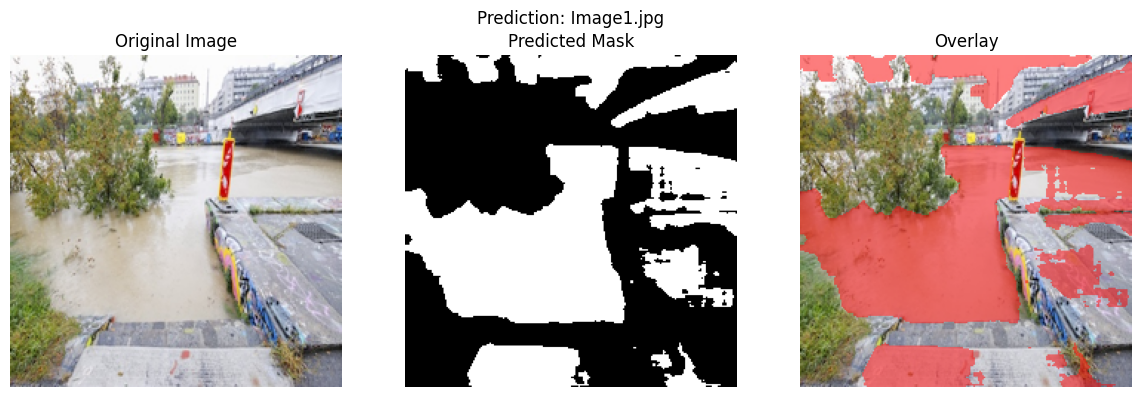

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


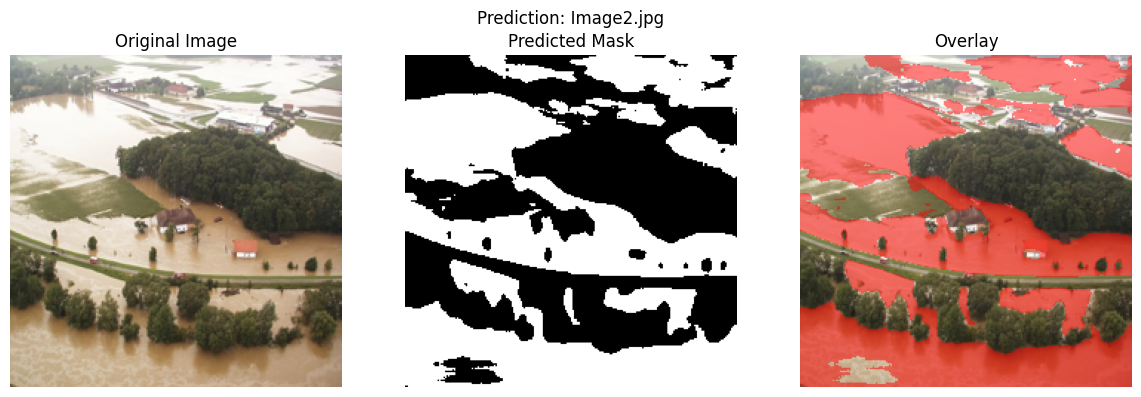

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


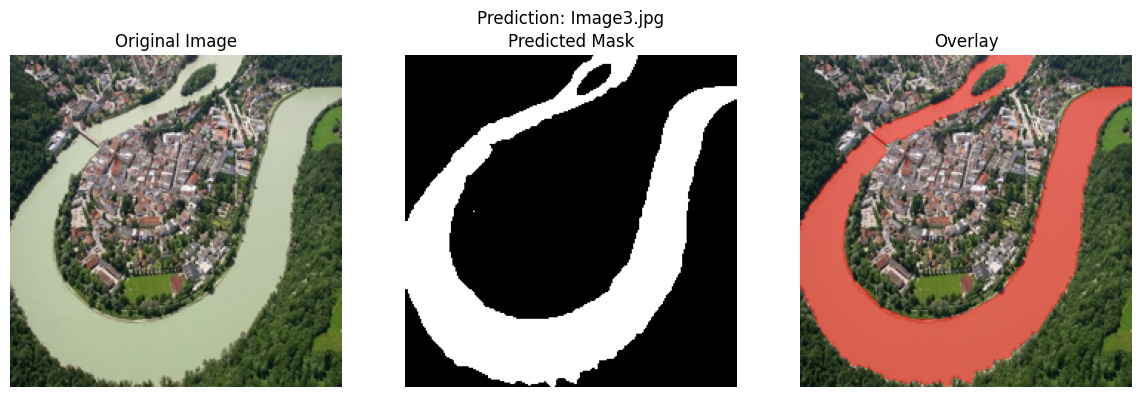

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


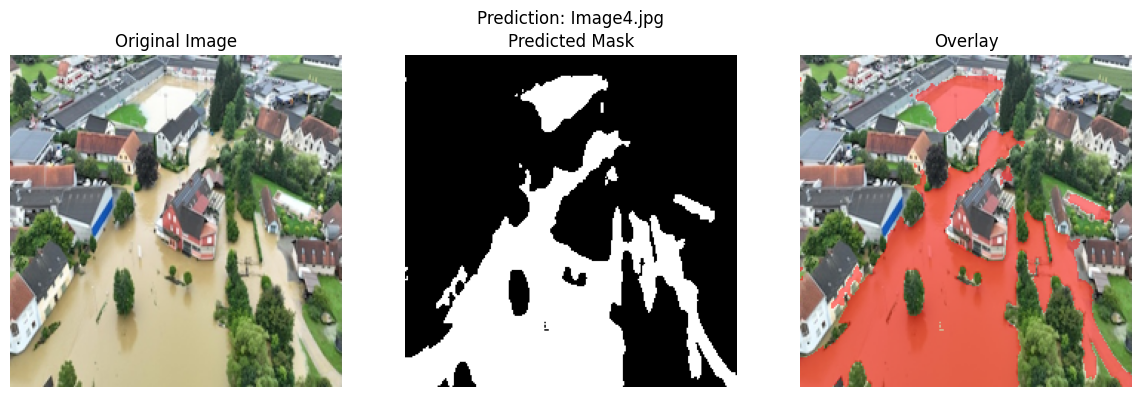

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


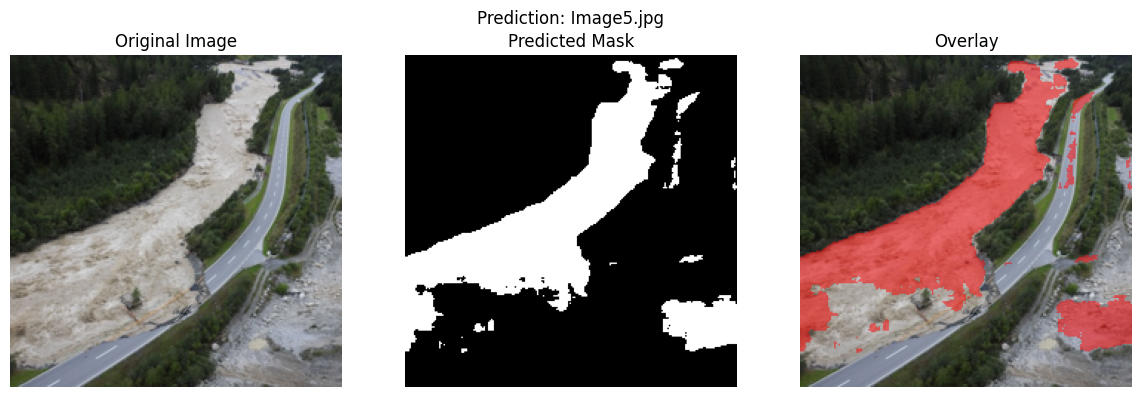

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


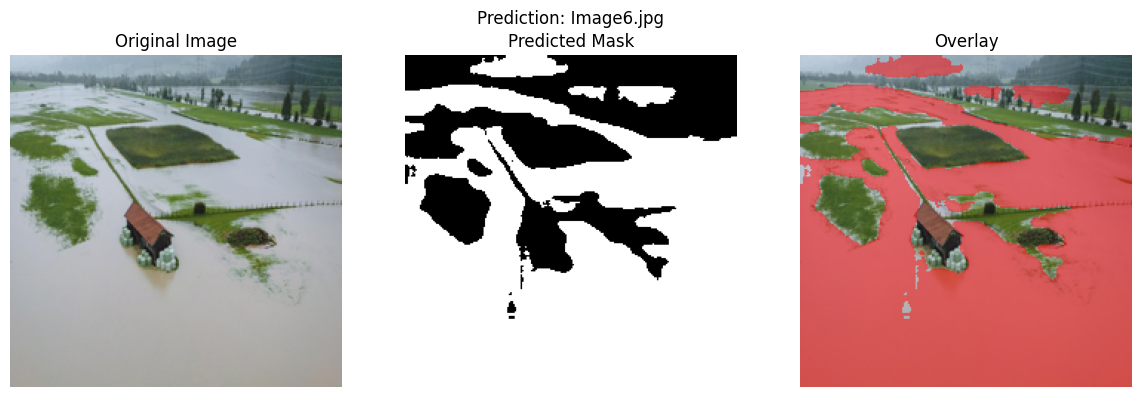

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


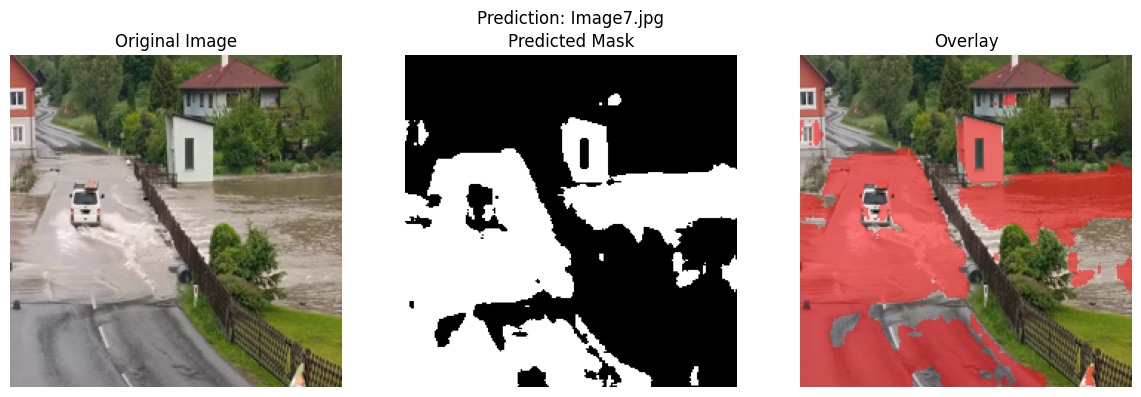

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


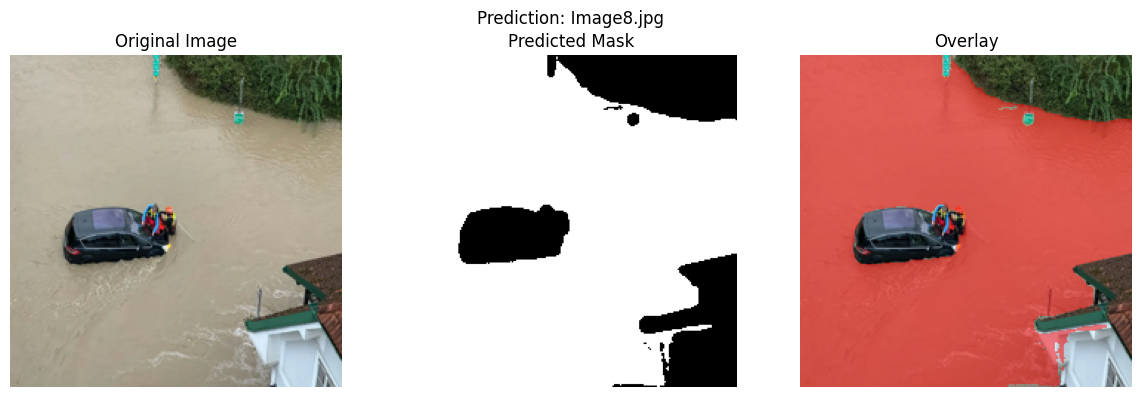

In [44]:
import import_ipynb
from utils.visualize_prediction import visualize_prediction
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model

IMG_HEIGHT, IMG_WIDTH = 224, 224
IMAGE_FOLDER = 'flood_images'  
ALPHA = 0.5  # Transparency of the mask

# load the model
model = load_model(f'./trained_models/{notebook_title}_batch_size_{BATCH_SIZE}.keras', compile=False)

# use images for predictions
image_files = sorted(os.listdir(IMAGE_FOLDER))
for img_file in image_files:
    img_path = os.path.join(IMAGE_FOLDER, img_file)
    
    # preparation
    image = Image.open(img_path).convert("RGB")
    image_resized = image.resize((IMG_WIDTH, IMG_HEIGHT))
    image_array = np.array(image_resized) / 255.0
    input_tensor = np.expand_dims(image_array, axis=0)  # Shape: (1, H, W, 3)

    # prediction
    pred_mask = model.predict(input_tensor)[0, :, :, 0]  # Shape: (H, W)
    pred_binary = (pred_mask > 0.5).astype(np.uint8)

    visualize_prediction(
        image_resized=np.array(image_resized), 
        pred_binary=pred_binary, 
        img_file=img_file,
        alpha=ALPHA,
        is_saved=True,
        save_title=f"adjusted_hyperparameter_batch_size_64"
    )